# OSM Lab: Econ Problem Set 1
## Rebekah Dix
### June 25th, 2018

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import numba
import ar1_approx

# to print plots inline
%matplotlib inline

# Exercise 2: Neoclassical Growth Model

### Set parameter values

In [2]:
gamma = .5
beta = .96
delta = .05
alpha = .4
sigmaz = .2
mu = 0
rho = 0

### Create grid space

In [3]:
'''
------------------------------------------------------------------------
Create Grid for State Space and Shock Space 
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
size_z    = integer, number of grid points in shock state space
z_grid    = vector, size_z x 1 vector of shock grid points
pi        = matrix, size_z x size_z matrix of transition probabilities of shocks
------------------------------------------------------------------------
'''
# State Space
lb_k = 10
ub_k = 13
size_k = 40  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

# Shock Space
size_z = 40  # Number of shocks
# We can simulate an iid process by using an AR(1) process where rho = 1
# In this way, the ar1_approx.py script will calculate the appropriate
# transition probabilties
ln_z_grid, pi_t = ar1_approx.addacooper(size_z, mu, rho, sigmaz)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)

### Create grid of current utility values

In [4]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c= z*(k**α) + (1 - δ)k - k')
U        = matrix, current period utility value for all possible
           choices of k, k', and z
------------------------------------------------------------------------
'''
C = np.zeros((size_k, size_k, size_z)) 
for i, k in enumerate(k_grid): # loop over k
    for j, kprime in enumerate(k_grid): # loop over k'
        for ii, z in enumerate(z_grid): # loop over z
            C[i, j, ii] = z * (k ** alpha) + (1 - delta)*k - kprime
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

In [5]:
#@numba.jit
def VFI_1_loop():
    '''
    ------------------------------------------------------------------------
    Value Function Iteration    
    ------------------------------------------------------------------------
    VFtol     = scalar, tolerance required for value function to converge
    VFdist    = scalar, distance between last two value functions
    VFmaxiter = integer, maximum number of iterations for value function
    V         = vector, the value functions at each iteration
    Vmat      = matrix, the value for each possible combination of w and w'
    Vstore    = matrix, stores V at each iteration 
    VFiter    = integer, current iteration number
    TV        = vector, the value function after applying the Bellman operator
    PF        = vector, indicies of choices of w' for all w 
    VF        = vector, the "true" value function
    ------------------------------------------------------------------------
    '''
    VFtol = 1e-6
    VFdist = 7.0 
    VFmaxiter = 400
    V = np.zeros((size_k, size_z)) # initial guess at value function
    Vmat = np.zeros((size_k, size_k, size_z)) # initialize Vmat matrix
    Vstore = np.zeros((size_k, size_k, VFmaxiter)) #initialize Vstore array
    VFiter = 1 
    while VFdist > VFtol and VFiter < VFmaxiter:  
        for i, k in enumerate(k_grid): # loop over k
            for j, kprime in enumerate(k_grid): # loop over k'
                for ii, z in enumerate(z_grid): # loop over z

                    # Calcuate expected value of future
                    EV = 0
                    for jj, zprime in enumerate(z_grid): # loop over z'
                        EV += pi[ii, jj]*V[j, jj]
                    Vmat[i, j, ii] = U[i, j, ii] + beta * EV

        #Vstore[:, :, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later

        TV = Vmat.max(1) # Take max over k' axis
        PF = np.argmax(Vmat, axis=1)
        VFdist = (np.absolute(V - TV)).max()  # check distance
        V = TV
        VFiter += 1 
    if VFiter < VFmaxiter:
        print('Value function converged after this many iterations:', VFiter)
    else:
        print('Value function did not converge')            


    VF = V # solution to the functional equation
    
    return VF, PF

In [6]:
VF, PF = VFI_1_loop()

Value function converged after this many iterations: 367


### Extract decision rules from solution

In [7]:
'''
------------------------------------------------------------------------
Find consumption and capital policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of k' for each k
optC  = vector, the optimal choice of c for each k
------------------------------------------------------------------------
'''
optK = k_grid[PF] # tomorrow's optimal cake size (savings function)
optC = z_grid * (k_grid ** alpha) + (1 - delta) * k_grid - optK

## Output Visualization

### Plot Value Function

<Figure size 432x288 with 0 Axes>

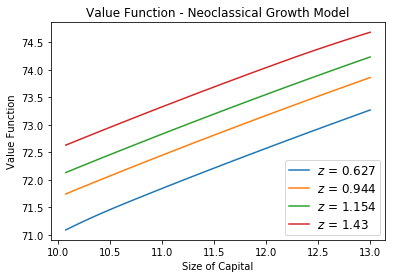

In [8]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(round(z_grid[0], 3)))
ax.plot(k_grid[1:], VF[1:, 15], label='$z$ = ' + str(round(z_grid[15], 3)))
ax.plot(k_grid[1:], VF[1:, 30], label='$z$ = ' + str(round(z_grid[30], 3)))
ax.plot(k_grid[1:], VF[1:, 38], label='$z$ = ' + str(round(z_grid[38], 3)))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital')
plt.ylabel('Value Function')
plt.title('Value Function - Neoclassical Growth Model')
plt.show()

### Plot optimal consumption rule

<Figure size 432x288 with 0 Axes>

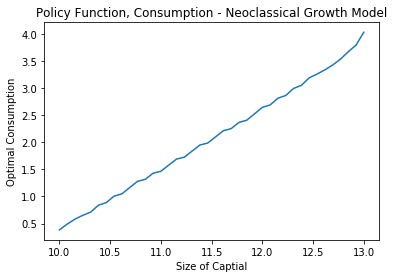

In [9]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][20])
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Captial')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, Consumption - Neoclassical Growth Model')
plt.show()

### Plot optimal capital rule

<Figure size 432x288 with 0 Axes>

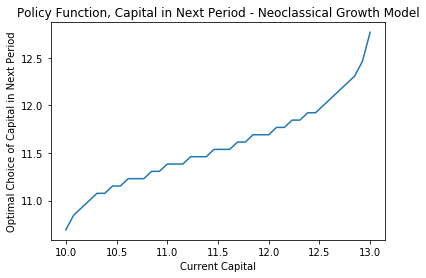

In [10]:
#Plot optimal capital rule as a function of current capital stock
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optK[:][20])
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Current Capital')
plt.ylabel('Optimal Choice of Capital in Next Period')
plt.title('Policy Function, Capital in Next Period - Neoclassical Growth Model')
plt.show()

# Exercise 3: Neoclassical Growth Model with AR(1) shocks

### Set parameter values

In [11]:
gamma = .5
beta = .96
delta = .05
alpha = .4
sigmav = .1
mu = 0
rho = .8

### Create grid space

In [12]:
'''
------------------------------------------------------------------------
Create Grid for State Space and Shock Space 
------------------------------------------------------------------------
lb_k      = scalar, lower bound of capital grid
ub_k      = scalar, upper bound of capital grid 
size_k    = integer, number of grid points in capital state space
k_grid    = vector, size_k x 1 vector of capital grid points 
size_z    = integer, number of grid points in shock state space
z_grid    = vector, size_z x 1 vector of shock grid points
pi        = matrix, size_z x size_z matrix of transition probabilities of shocks
------------------------------------------------------------------------
'''
# State Space
lb_k = 10
ub_k = 13
size_k = 40  # Number of grid points
k_grid = np.linspace(lb_k, ub_k, size_k)

# Shock Space
size_z = 40  # Number of shocks
# We can simulate an iid process by using an AR(1) process where rho = 1
# In this way, the ar1_approx.py script will calculate the appropriate
# transition probabilties
ln_z_grid, pi_t = ar1_approx.addacooper(size_z, mu, rho, sigmav)
z_grid = np.exp(ln_z_grid)
pi = np.transpose(pi_t)

### Create grid of current utility values

In [13]:
'''
------------------------------------------------------------------------
Create grid of current utility values    
------------------------------------------------------------------------
C        = matrix, current consumption (c=z*(k**α) + (1 - δ)k - k')
U        = matrix, current period utility value for all possible
           choices of k, k', and z
------------------------------------------------------------------------
'''
C = np.zeros((size_k, size_k, size_z)) 
for i, k in enumerate(k_grid): # loop over k
    for j, kprime in enumerate(k_grid): # loop over k'
        for ii, z in enumerate(z_grid): # loop over z
            C[i, j, ii] = z * (k ** alpha) + (1 - delta)*k - kprime
# replace 0 and negative consumption with a tiny value 
# This is a way to impose non-negativity on cons
C[C<=0] = 1e-15
if gamma == 1:
    U = np.log(C)
else:
    U = (C ** (1 - gamma)) / (1 - gamma)
U[C<0] = -9999999

In [14]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-5 
VFdist = 7.0 
VFmaxiter = 400
V = np.zeros((size_k, size_z)) # initial guess at value function
Vmat = np.zeros((size_k, size_k, size_z)) # initialize Vmat matrix
Vstore = np.zeros((size_k, size_k, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while VFdist > VFtol and VFiter < VFmaxiter:  
    for i, k in enumerate(k_grid): # loop over k
        for j, kprime in enumerate(k_grid): # loop over k'
            for ii, z in enumerate(z_grid): # loop over z
                
                # Calcuate expected value of future
                EV = 0
                for jj, zprime in enumerate(z_grid):
                    EV += pi[ii, jj]*V[j, jj]
                Vmat[i, j, ii] = U[i, j, ii] + beta * EV

    #Vstore[:, :, VFiter] = V.reshape(size_k, size_z,) # store value function at each iteration for graphing later

    TV = Vmat.max(1) # Take max over k' axis
    PF = np.argmax(Vmat, axis=1)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 310


### Extract decision rules from solution

In [15]:
'''
------------------------------------------------------------------------
Find consumption and capital policy functions   
------------------------------------------------------------------------
optK  = vector, the optimal choice of k' for each k
optC  = vector, the optimal choice of c for each k
------------------------------------------------------------------------
'''
optK = k_grid[PF] # tomorrow's optimal cake size (savings function)
optC = z_grid * (k_grid ** alpha) + (1 - delta) * k_grid - optK

## Output Visualization

### Plot Value Function

<Figure size 432x288 with 0 Axes>

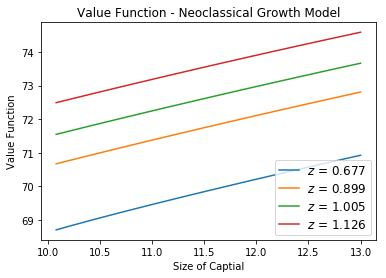

In [16]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], VF[1:, 0], label='$z$ = ' + str(round(z_grid[0], 3)))
ax.plot(k_grid[1:], VF[1:, 10], label='$z$ = ' + str(round(z_grid[10], 3)))
ax.plot(k_grid[1:], VF[1:, 20], label='$z$ = ' + str(round(z_grid[20], 3)))
ax.plot(k_grid[1:], VF[1:, 30], label='$z$ = ' + str(round(z_grid[30], 3)))
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Captial')
plt.ylabel('Value Function')
plt.title('Value Function - Neoclassical Growth Model')
plt.show()

### Plot optimal consumption rule

<Figure size 432x288 with 0 Axes>

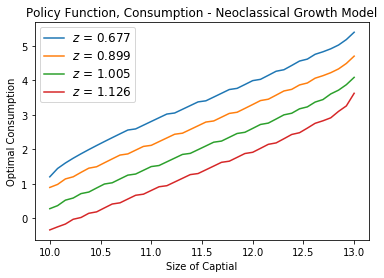

In [17]:
#Plot optimal consumption rule as a function of capital size
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[:], optC[:][0], label='$z$ = ' + str(round(z_grid[0], 3)))
ax.plot(k_grid[:], optC[:][10], label='$z$ = ' + str(round(z_grid[10], 3)))
ax.plot(k_grid[:], optC[:][20], label='$z$ = ' + str(round(z_grid[20], 3)))
ax.plot(k_grid[:], optC[:][30], label='$z$ = ' + str(round(z_grid[30], 3)))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Captial')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, Consumption - Neoclassical Growth Model')
plt.show()

### Plot optimal capital rule

<Figure size 432x288 with 0 Axes>

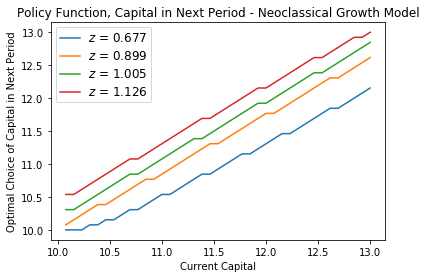

In [18]:
#Plot optimal capital rule as a function of current capital stock
plt.figure()
fig, ax = plt.subplots()
ax.plot(k_grid[1:], optK[1:,0], label='$z$ = ' + str(round(z_grid[0], 3)))
ax.plot(k_grid[1:], optK[1:,10], label='$z$ = ' + str(round(z_grid[10], 3)))
ax.plot(k_grid[1:], optK[1:,20], label='$z$ = ' + str(round(z_grid[20], 3)))
ax.plot(k_grid[1:], optK[1:,30], label='$z$ = ' + str(round(z_grid[30], 3)))
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Current Capital')
plt.ylabel('Optimal Choice of Capital in Next Period')
plt.title('Policy Function, Capital in Next Period - Neoclassical Growth Model')
plt.show()

# Exercise 4: Search and matching model

In [19]:
# Set Parameters
beta = .96
size_b = 20
b = np.linspace(.05, 1, size_b) # unemployment benefits
sigma = .15 # standard deviation of log wage draws
mu = 0
rho = 0

size_w = 100
# We can simulate an iid process by using an AR(1) process where rho = 1
# In this way, the ar1_approx.py script will calculate the appropriate
# transition probabilties
ln_wage_grid, pi_t = ar1_approx.addacooper(size_w, mu, rho, sigma)
w_grid = np.exp(ln_wage_grid)
pi = np.transpose(pi_t)

# Utility values of accepting a wage offer
U = w_grid / (1 - beta)

In [20]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol       = scalar, tolerance required for value function to converge
VFdist      = scalar, distance between last two value functions
VFmaxiter   = integer, maximum number of iterations for value function
V           = matrix, the value functions at each iteration
TV          = matrix, the value function after applying the Bellman operator
PF_discrete = matrix, matrix of policy function: eat=1, not eat=0 
Vstore      = array, stores V at each iteration 
VFiter      = integer, current iteration number
EV          = scalar, expected value function for a given state
U_eat       = matrix, utility from eating cake now
Vwait       = matrix, value of waiting to eat the cake
VF          = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 3000 
V = np.zeros((size_w, size_b)) # initial guess at value function
TV = np.zeros((size_w, size_b))
PF_discrete = np.zeros((size_w, size_b))
Vstore = np.zeros((size_w, size_b, VFmaxiter)) #initialize Vstore array
VFiter = 1 
while (VFdist > VFtol and VFiter < VFmaxiter):
    for i in range(size_w): # loop over w
        for j, bVal in enumerate(b):
   
            EV = 0
            for ii in range(size_w):  # loop over w
                EV += pi[i, ii] * V[ii, j]  
            
            U_accept = U[i]
                
            V_wait = bVal + beta * EV 
            TV[i, j] = max(U_accept, V_wait)
            PF_discrete[i, j] = U_accept >= V_wait  
            
    Vstore[:,:, VFiter] = TV # store value function at each iteration for graphing later 
    VFdist = (np.absolute(V - TV)).max()  # check distance
    V = TV
    VFiter += 1 

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Value function converged after this many iterations: 3


### Calculate Reservation Wage

In [21]:
reservation_wage = w_grid[np.argmax(PF_discrete, axis=0)]
print(reservation_wage[0]) # reservation wage for b = .05
print(reservation_wage) # reservation wage over range of values: b = .05 to 1

1.0327303478475856
[1.03273035 1.03672313 1.04075636 1.04483344 1.04483344 1.048958
 1.05313387 1.05736513 1.06165615 1.0660116  1.07043651 1.07493631
 1.07493631 1.07951689 1.08418465 1.0889466  1.09381039 1.09878449
 1.09878449 1.10387824]


## Output Visualization

### Plot Value Function

<Figure size 432x288 with 0 Axes>

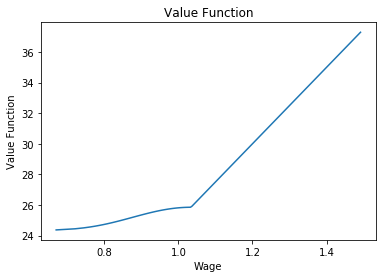

In [22]:
# Plot value function 
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[:], VF[:,1])

for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Wage')
plt.ylabel('Value Function')
plt.title('Value Function')
plt.show()

### Plot Reservation Wage and Unemployment Benefits

Comparative statics: Observe that increasing the unemployment benefits increases the reservation wage. 

<Figure size 432x288 with 0 Axes>

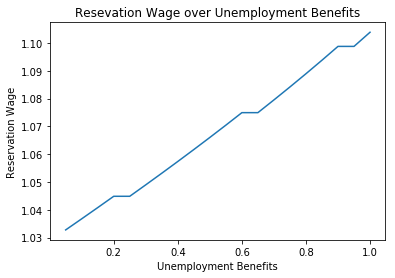

In [23]:
# Plot reservation wage and unemployement benefits
plt.figure()
fig, ax = plt.subplots()
ax.plot(b[:], reservation_wage[:])
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Unemployment Benefits')
plt.ylabel('Reservation Wage')
plt.title('Resevation Wage over Unemployment Benefits')
plt.show()